# Описание проекта
   - Задача — оценить корректность проведения теста; провести оценку результатов A/B-теста
   - Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
   - Группы: А (контрольная), B (новая платёжная воронка);
   - Дата запуска: 2020-12-07;
   - Дата остановки набора новых пользователей: 2020-12-21;
   - Дата остановки: 2021-01-04;
   - Аудитория: 15% новых пользователей из региона EU;
   - Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем      на 10%:

# Подготовка данных к анализу

## Выгрузка всех необходимых библиотек

In [47]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from numpy import median
from plotly import graph_objects as go

## Выгрузка  исходных данных

In [48]:
events_new_users, marketing_events, new_users,test_users = (
    pd.read_csv('/datasets/final_ab_events.csv'), # действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 год
    pd.read_csv('/datasets/ab_project_marketing_events.csv'), #  календарь маркетинговых событий на 2020 год
    pd.read_csv('/datasets/final_ab_new_users.csv'),  # пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
    pd.read_csv('/datasets/final_ab_participants.csv') # таблица участников тестов
)

In [49]:
dfs = [events_new_users, marketing_events, new_users,test_users]
for df in dfs:
    df.info()
    display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


### Вывод
     - выгрузили все необходимые данные для анализа:
     - events_new_users-действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 год
     - marketing_events-календарь маркетинговых событий на 2020 год
     - new_users-пользователи-зарегистрировавшиеся с 7 по 21 декабря 2020 года
     - test_users-таблица участников тестов
     - обнаружено несоответствие типов данных в столбцах ('event_dt','start_dt','finish_dt','first_date')

## Предобработка данных

### Изучение пропусков

В датафрейме "events_new_users" есть пропуски в столбце "details"-это размер покупки
Смотрим кол-во событий в столбце 'event_name', являющееся покупкой. Их как раз 62470. Убедились, что пропуски-это N/A
Можем заменить их на "no_purchase"

In [50]:
# изучение пропусков
len(events_new_users.query('event_name=="purchase"')) # кол-во событий покупки
events_new_users['details'] = events_new_users['details'].fillna('no_purchase')

### Проверка на дубликаты

In [51]:
# проверка на дубликаты
for df in dfs:
    print('Кол-во дубликатов: ', df.duplicated().sum())

Кол-во дубликатов:  0
Кол-во дубликатов:  0
Кол-во дубликатов:  0
Кол-во дубликатов:  0


### Приведение к нужным форматам

In [52]:
# переводи столбцы с датами в соответствующий формат
events_new_users['event_dt'] = pd.to_datetime(events_new_users['event_dt']).dt.date
events_new_users['event_dt'] = events_new_users['event_dt'].astype('datetime64[ns]')
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])


### Проверка на числовые форматы и  неявные дубликаты

In [53]:
# проверяем на наличие отрицательных значений
def find_num_cols(df):
    numerical_columns = [c for c in df.columns if df[c].dtype.name =='int64'] # выбираем только столбцы с количественными данными	
    return numerical_columns

for df in dfs:
    numeric = find_num_cols(df)# список столбцов с количественными данными присваивается переменной 'numeric'
    for i in numeric:
        df[i] = df[i].abs()
print()
# проверяем категориальные столбцы на неочевидные пропукси и дубликаты
def find_cat_cols(df):
    categorial_columns = [c for c in df.columns if df[c].dtype.name == 'object'] #выбираем только столбцы с категориальными данными
    return categorial_columns

for df in dfs:
    categorial = find_cat_cols(df)
    for i in categorial:
        print(df[i].unique())
        print()


['E1BDDCE0DAFA2679' '7B6452F081F49504' '9CD9F34546DF254C' ...
 'C9F1399FDCD83F13' '4F32B58E4FF19DC5' '27767D4BECDD260E']

['purchase' 'product_cart' 'product_page' 'login']

[99.99 9.99 4.99 499.99 'no_purchase']

['Christmas&New Year Promo' "St. Valentine's Day Giveaway"
 "St. Patric's Day Promo" 'Easter Promo' '4th of July Promo'
 'Black Friday Ads Campaign' 'Chinese New Year Promo'
 'Labor day (May 1st) Ads Campaign' "International Women's Day Promo"
 'Victory Day CIS (May 9th) Event' 'CIS New Year Gift Lottery'
 'Dragon Boat Festival Giveaway' "Single's Day Gift Promo"
 'Chinese Moon Festival']

['EU, N.America' 'EU, CIS, APAC, N.America' 'N.America' 'APAC'
 'EU, CIS, APAC' 'CIS']

['D72A72121175D8BE' 'F1C668619DFE6E65' '2E1BF1D4C37EA01F' ...
 '7ADEE837D5D8CBBD' '1C7D23927835213F' '8F04273BB2860229']

['EU' 'N.America' 'APAC' 'CIS']

['PC' 'Android' 'iPhone' 'Mac']

['D1ABA3E2887B6A73' 'A7A3664BD6242119' 'DABC14FDDFADD29E' ...
 'F501F79D332BE86C' '63FBE257B05F2245' '79F9ABFB029CF7

### Вывод
    - Проведена вычистка данных на предмет:
    - явных и неявных пропусков
    - задвоений
    - некорректных форматов данных

## Оценка корректности проведения A/B теста

### Проверка соответствия техническому заданию

In [54]:
# проверяем, соответствует ли кол-во участников теста заявленному в ТЗ
test_system = test_users.query('ab_test=="recommender_system_test"')
print('Общее кол-во участников A/B теста: ',len(test_system['user_id'].unique()))
display(test_users.head())

Общее кол-во участников A/B теста:  6701


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Кол-во 6701 превышает заявленное в ТЗ 6000. В целом, мы набрали искомые 6тыс юзеров.

In [55]:
# проверяем соответствует ли число в 15% новых пользователей из EU из региона в ТЗ ресльности
print('15% новых пользователей из региона "EU":',mth.trunc(len(new_users.query('region=="EU"')['user_id'].unique())*0.15))
display(new_users.head())

15% новых пользователей из региона "EU": 6940


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Кол-во явно отличается. Проверим качество (действительно ли пользователи теста из новых и из региона "EU")

In [56]:
new_users_EU = new_users.query('region=="EU"')['user_id'].unique()# все новые пользователи из Европы

test_system_new_EU = test_system[test_system['user_id'].isin(new_users_EU)] # пользователи для теста
display(test_system_new_EU.head())
print('Кол-во  пользователей из новых в Европе: ',len(new_users_EU))
print('Кол-во тестовых пользователей из новых в Европе: ',len(test_system_new_EU))
print('Процент тестовых пользователей из новых в Европе: ',round(len(test_system_new_EU)/len(new_users_EU)*100,2))

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Кол-во  пользователей из новых в Европе:  46270
Кол-во тестовых пользователей из новых в Европе:  6351
Процент тестовых пользователей из новых в Европе:  13.73


Проверяем разницу в заявленной и фактической долях на статистическую значимость
Нулевая гипотеза, доли пользователей равны-Ho
Альтернативная гипотеза-между долями есть статистически значимая разница-H1

In [57]:
alpha = 0.05
p1 = 0.15
p2 = 0.1373
    
# транслируем полученные доли
print('Доли в каждой группе: ',p1,p2)
print('Разница в долях: ',round(p1/p2,2))
          
p_combined = 13291/92540
difference = p1-p2
z_value = difference/mth.sqrt(p_combined*(1-p_combined)*(1/46270+1/46270)) 

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0,1)
    
p_value = (1-distr.cdf(abs(z_value)))*2 
            
print('p-значение: ', p_value)
if p_value < alpha: 
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
         )

Доли в каждой группе:  0.15 0.1373
Разница в долях:  1.09
p-значение:  3.629775346958297e-08
Отвергаем нулевую гипотезу: между долями есть значимая разница


В ТЗ было заявлено, что кол-во участников для теста должно составлять 15% новых пользователей из Европы, т.е. 6940
По факту оно составляет 14% - 6351. Проверка выше показала, что между долями есть статистически значимая разница

Процент отброшенных пользователей, из других регионов

In [58]:
test_system_regions = test_system[~test_system['user_id'].isin(new_users_EU)]
print('Процент тестовых пользователей из других регионов: ',round(len(test_system_regions['user_id'].unique())/len(test_system['user_id'].unique())*100,2))
lost_region = test_system_regions.merge(new_users, on='user_id',how='left').groupby('region').agg({'user_id':'nunique'})
lost_region['share_user'] = round(lost_region['user_id']/lost_region['user_id'].sum()*100,2)
display(lost_region)

Процент тестовых пользователей из других регионов:  5.22


,user_id,share_user
region,,
APAC,72,20.57
CIS,55,15.71
N.America,223,63.71


### Проверка пересечений пользователей и маркетинговых активностей с датами теста:
    - между разными тестами
    - между двумя группами теста
    - время проведения теста  не совпадает с
      маркетинговыми и другими активностями

In [59]:
test_users['ab_test'].unique()
len(test_users.query('ab_test=="interface_eu_test"')['user_id'].unique())

11567

In [60]:
# проверим на наличие пользователей попавших в оба теста 

usersT1 = test_system_new_EU.groupby('user_id').agg({'user_id':'first'})
usersT1.columns=['id']
def common_test(group):
    usersT2 = test_users[(test_users['ab_test']=='interface_eu_test')&(test_users['group']==group)].groupby('user_id').agg({'user_id':'first'})
    usersT2.columns=['id']

    common_test = (pd.concat([usersT1,usersT2],axis=0))# кол-во общих пользователей на 2 группы
    common_test = common_test[common_test.duplicated()]['id'].tolist()
    return common_test
    
common_a = common_test('A')
print('Кол-во пересекающихся юзеров из контрольной группы, участвующих сразу в двух тестах  равно: ',len(common_a))
common_b = common_test('B')
print('Кол-во пересекающихся юзеров из тестовой группы, участвующих сразу в двух тестах равно: ',len(common_b))
#test_clean = test_system_new_EU.query('user_id not in @common_test')
#test_clean.info()

Кол-во пересекающихся юзеров из контрольной группы, участвующих сразу в двух тестах  равно:  819
Кол-во пересекающихся юзеров из тестовой группы, участвующих сразу в двух тестах равно:  783


In [61]:
# доля участников другого теста (контрольная группа) в каждой из 2-х групп текущего теста:
test_common_A_a = round(len(test_system_new_EU.query('group=="A" and user_id in @common_a'))/len(test_system_new_EU.query('group=="A"'))*100,2)
test_common_B_a = round(len(test_system_new_EU.query('group=="B" and user_id in @common_a'))/len(test_system_new_EU.query('group=="B"'))*100,2)

print('Процент пересекающихся юзеров в A группе, участвующих заодно в контрольной группе другого теста: ',test_common_A_a) 
print()
print('Процент пересекающихся юзеров в B группе, участвующих заодно в контрольной группе другого теста: ', test_common_B_a)

Процент пересекающихся юзеров в A группе, участвующих заодно в контрольной группе другого теста:  13.26

Процент пересекающихся юзеров в B группе, участвующих заодно в контрольной группе другого теста:  12.4


In [62]:
# доля участников другого теста (тестовая группа) в каждой из 2-х групп текущего теста
test_common_A_b = round(len(test_system_new_EU.query('group=="A" and user_id in @common_b'))/len(test_system_new_EU.query('group=="A"'))*100,2)
test_common_B_b = round(len(test_system_new_EU.query('group=="B" and user_id in @common_b'))/len(test_system_new_EU.query('group=="B"'))*100,2)

print('Процент пересекающихся юзеров в A группе, участвующих заодно в тестовой группе другого теста: ',test_common_A_b) 
print()
print('Процент пересекающихся юзеров в B группе, участвующих заодно в тестовой группе другого теста: ', test_common_B_b)

Процент пересекающихся юзеров в A группе, участвующих заодно в тестовой группе другого теста:  12.08

Процент пересекающихся юзеров в B группе, участвующих заодно в тестовой группе другого теста:  12.66


Так как процент попавших в оба теста юзеров фактически идентичен, а микс мы условно считаем однородным, то оставляем кол-ва в тесте.

In [63]:
# проверка пересечения между 2-мя группами пользователей
usersA = test_system_new_EU[test_system_new_EU['group']=="A"].groupby('user_id').agg({'user_id':'first'})
usersA.columns=['id']
usersB = test_system_new_EU[test_system_new_EU['group']=="B"].groupby('user_id').agg({'user_id':'first'})
usersB.columns=['id']

common_group = (pd.concat([usersA,usersB],axis=0))# кол-во общих пользователей на 2 группы
common_group = common_group[common_group.duplicated()]['id'].tolist()
print('Кол-во пересекающихся юзеров, участвующих сразу в двух тестах равно: ',len(common_group))
test_system_new_EU = test_system_new_EU.query('user_id not in @common_group')
test_system_new_EU.info()


Кол-во пересекающихся юзеров, участвующих сразу в двух тестах равно:  0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6351 entries, 0 to 6350
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  6351 non-null   object
 1   group    6351 non-null   object
 2   ab_test  6351 non-null   object
dtypes: object(3)
memory usage: 198.5+ KB


Проверяем, что время проведения теста  не совпадает с маркетинговыми и другими активностями

In [64]:
# пишем формулу для выяснения: была ли маркетинговая акция в тестовом регионе (тут допускаю, что если пользователи из EU, то и сам тест проводился в EU)
def check_region(x):
    if "EU" in x:
        return 'ok'
    return 'no'

marketing_events['region_test'] = marketing_events['regions'].apply(check_region)
marketing_events_test = marketing_events.query('region_test=="ok"')

Смотрим, когда происходили маркетинговые активности. Помним, что наш период теста с 7 декабря 2020 по 4 января 2021.
Важно, чтобы период теста не пересекался с маркетинговыми активностями, что может повлиять на результат.

In [65]:
print(marketing_events_test['start_dt'].min())
print(marketing_events_test['finish_dt'].max())
display(marketing_events_test.sort_values(by='start_dt'))

2020-02-14 00:00:00
2021-01-03 00:00:00


,name,regions,start_dt,finish_dt,region_test
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,ok
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,ok
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,ok
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,ok
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,ok
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,ok
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,ok


Видим, что большая часть маркетинговых активностей в интересующем нас регионе завершилась еще до начала теста, т. е до 07.12.2020, КРОМЕ последней акции в таблице выше, проходившей с 25 декабря до 3 января. Соответственно наш observation date для нашего теста- 24.12 2020. Так как новые пользователи продолжали приходить до 21.12.2020 включительно, горизон анализа 14 дней, то часть пользователей в анализ не попадет.

Проверим, какой процент от участников нашего теста пересекается  с маркетинговым событием в таком случае.

In [66]:
# корректируем кол-во участников теста с учетом  информации выше
observation_date = datetime(2020,12,24).date()
horizon_days = 14
last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
   
new_users_test = new_users.query('first_date<=@last_suitable_acquisition_date')

In [67]:
# объединяем тестовых пользователей с событиями.
test_cut = test_system_new_EU.merge(new_users_test, on=['user_id'],how='left')# объединяем тестовых юзеров с их профайлами
test_market = test_cut[test_cut['region'].isna()]

print('Кол-во пользователей, которые попадают в маркетинговое событие: ',len(test_market))
print()
print('Кол-во пользователей, которые попадают в маркетинговое событие из группы A: ',len(test_market.query('group=="A"')))
print('Кол-во пользователей, которые попадают в маркетинговое событие из группы B: ',len(test_market.query('group=="B"')))

Кол-во пользователей, которые попадают в маркетинговое событие:  4527

Кол-во пользователей, которые попадают в маркетинговое событие из группы A:  2610
Кол-во пользователей, которые попадают в маркетинговое событие из группы B:  1917


Кол-во пользователей, которые мы предположительно должны исключить, составляет более половины ото всей выборки. Кол-во пользователей, чья деятельность попадает на период действия марекетингово события, в обоих группах примерно похожа. Оставляем эти данные.

In [68]:
# объединяем тестовых пользователей с событиями.
test_full = test_system_new_EU.merge(new_users, on=['user_id'],how='left')# объединяем тестовых юзеров с их профайлами
display(test_full.head())

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [69]:
#display(len(events_new_users['user_id'].unique()))
#display(len(new_users['user_id'].unique()))
sessions = test_full.merge(events_new_users,on='user_id',how='left')
sessions.info()

#display(sessions[sessions['event_dt'].isna()])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26290 entries, 0 to 26289
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     26290 non-null  object        
 1   group       26290 non-null  object        
 2   ab_test     26290 non-null  object        
 3   first_date  26290 non-null  datetime64[ns]
 4   region      26290 non-null  object        
 5   device      26290 non-null  object        
 6   event_dt    23420 non-null  datetime64[ns]
 7   event_name  23420 non-null  object        
 8   details     23420 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 2.0+ MB


In [70]:
# Не все новые пользователи совершали какие-либо действия, помимо регистрации. Заменим такие пропуски
sessions['event_name'] = sessions['event_name'].fillna('registration')
sessions['details'] = sessions['details'].fillna('no_purchase')
sessions['event_dt'] = sessions['event_dt'].fillna(0)

def change_date(row):
    event_dt=row['event_dt']
    first_date=row['first_date']
    if event_dt==0:
        return first_date
    return event_dt
sessions['event_dt'] = sessions.apply(change_date,axis=1)
display(sessions.query('user_id=="92CB588012C10D3D"'))

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
55,92CB588012C10D3D,A,recommender_system_test,2020-12-09,EU,PC,2020-12-09,product_page,no_purchase
56,92CB588012C10D3D,A,recommender_system_test,2020-12-09,EU,PC,2020-12-25,product_page,no_purchase
57,92CB588012C10D3D,A,recommender_system_test,2020-12-09,EU,PC,2020-12-09,login,no_purchase
58,92CB588012C10D3D,A,recommender_system_test,2020-12-09,EU,PC,2020-12-25,login,no_purchase


### Вывод
- Выборка для теста произведена некорректно, так как не соответствует ТЗ:
- выбранные пользователи не все соответствуют новым в регионе EU. Из 6700 выбранных участников теста 6300 из новых в            - Европе. По факту 15% из новых пользователей в Европе составляют 6940
- есть пересечение пользователй между 2-мя разными тестами. Доля общих участников в каждой из тестовых групп составляет          - 25%
- есть пересечение времени проведения теста с другой маркетинговой акцией: Christmas&New Year Promo, проводимой в EU,            - и N.America с 2020-12-25 по 2021-01-03. 30% и 40% от всех участников попадают в период проведения маркетинговой акции          - в группах А и В соответственно 

## EDA

### Распределение кол-ва событий на пользователя

In [71]:
print('Всего в логе событий: ', len(sessions['event_name']))
print()
print('Всего в логе событий уникальных: ', len(sessions['event_name'].unique()))
print('События  в логе: ',sessions['event_name'].unique())
print()
print('Всего в логе пользователей: ', len(sessions['user_id'].unique()))
print()

# расчет кол-ва событий на пользователя (всего и уникальных)
event_per_user = sessions.groupby('user_id').agg({'event_name':'count'}).reset_index()
event_per_user.columns = ['user_id','event_name']
event_per_user_avg = round(event_per_user['event_name'].mean(),0)

print('Среднее кол-во событий на пользователя: ', event_per_user_avg)
print()

event_per_user_unique = sessions.groupby('user_id').agg({'event_name':'nunique'}).reset_index() # кол-во уникальных событий на пользователя
event_per_user_unique.columns = ['user_id','event_name']
event_per_user_avg_unique = round(event_per_user_unique['event_name'].mean(),0)

print('Среднее кол-во событий на пользователя уникальных: ', event_per_user_avg_unique)


Всего в логе событий:  26290

Всего в логе событий уникальных:  5
События  в логе:  ['purchase' 'product_cart' 'product_page' 'login' 'registration']

Всего в логе пользователей:  6351

Среднее кол-во событий на пользователя:  4.0

Среднее кол-во событий на пользователя уникальных:  2.0


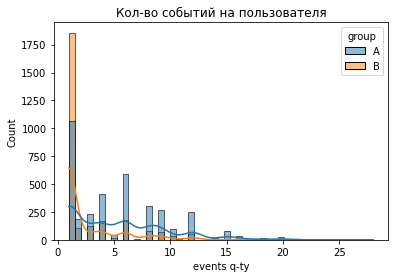

In [72]:
data_c = sessions.groupby(['group','user_id']).agg({'event_name':'count'})
data_c = data_c.rename(columns={'event_name':'events q-ty'})                       
sns.histplot(data_c,x=data_c['events q-ty'],hue ='group',kde=True,alpha=0.5)
plt.title('Кол-во событий на пользователя')
plt.show()

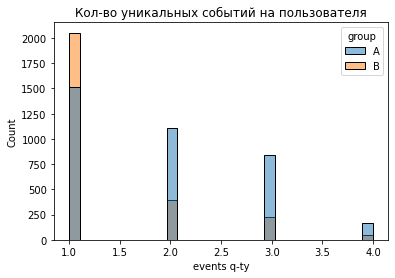

In [73]:
data_u = sessions.groupby(['group','user_id']).agg({'event_name':'nunique'})
data_u = data_u.rename(columns={'event_name':'events q-ty'})                       
sns.histplot(data_u,x=data_u['events q-ty'],hue ='group',alpha=0.5)
plt.title('Кол-во уникальных событий на пользователя')
plt.show()

События на пользователи распределены схожим образом в обеих группах.
Наибольшее кол-во пользователей с 1 событием, далее 2 и наименьшее кол-во 3

### Распределение кол-ва событий по дням


In [74]:
def quatity(event, horizon,dimension=[]):
    if len(event)==0:
        event_name  = sessions.groupby(['user_id','event_dt']).agg({'event_name':'count'}).rename(columns={'event_name':'q-ty'}).reset_index()

    event_name  = sessions.query('event_name==@event').groupby(['user_id','event_dt']).agg({'event_name':'count'}).rename(columns={'event_name':'q-ty'}).reset_index()
    test = test_full.merge(
         event_name[['user_id','event_dt', 'q-ty']], on='user_id', how='left')
    test.dropna(inplace=True)
    test['lifetime'] = (
        test['event_dt'] - test['first_date']
    ).dt.days
    result = test.pivot_table(
            index=dimension, columns='lifetime', values='q-ty', aggfunc='sum'
        )
      
    result = result[list(range(horizon))]
    return result

def plot_quantity(result,horizon,i):
    plt.figure(figsize=(10, 10))
    result.T.plot(kind='bar',grid=True,ax=plt.subplot(2,2,i+1))
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('{} per day:'.format(event))



Text(0.5, 1.0, 'Кол-во событий по дням')

<Figure size 1080x1440 with 0 Axes>

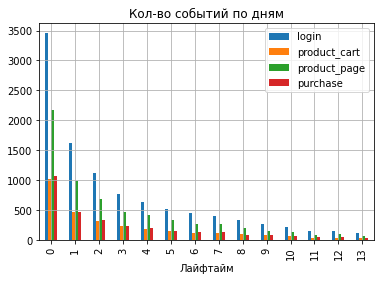

In [75]:
event_name  = sessions.query('event_name!="registration"').groupby(['user_id','event_dt','event_name']).agg({'event_name':'count'}).rename(columns={'event_name':'q-ty'}).reset_index()
test = test_full.merge(
         event_name[['user_id','event_dt','event_name', 'q-ty']], on='user_id', how='left')
test.dropna(inplace=True)
test['lifetime'] = (
        test['event_dt'] - test['first_date']
    ).dt.days
result = test.pivot_table(
            index='event_name', columns='lifetime', values='q-ty', aggfunc='sum'
        )
      
result = result[list(range(14))]
plt.figure(figsize=(15, 20))
result.T.plot(kind='bar',grid=True)
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Кол-во событий по дням')


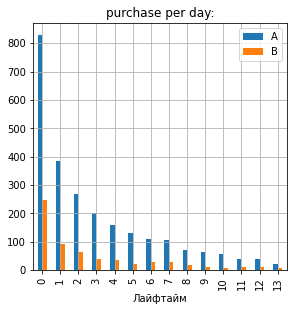

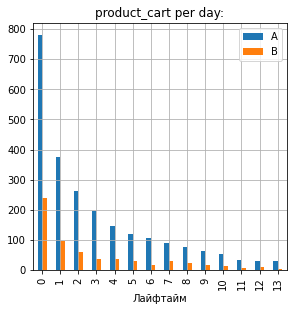

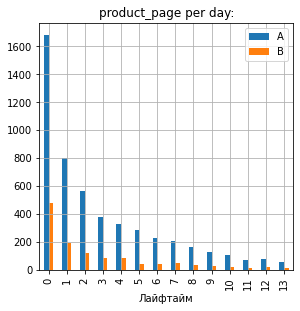

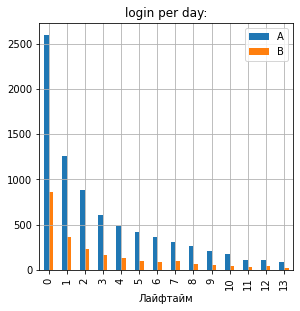

In [76]:
events = ['purchase', 'product_cart', 'product_page', 'login']
i=0
for event in events:
    result = quatity(event, 14,['group'])
    plot_quantity(result,14,i)
    i+=1

In [77]:
display(sessions.head())

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_cart,no_purchase
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,product_cart,no_purchase
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_page,no_purchase


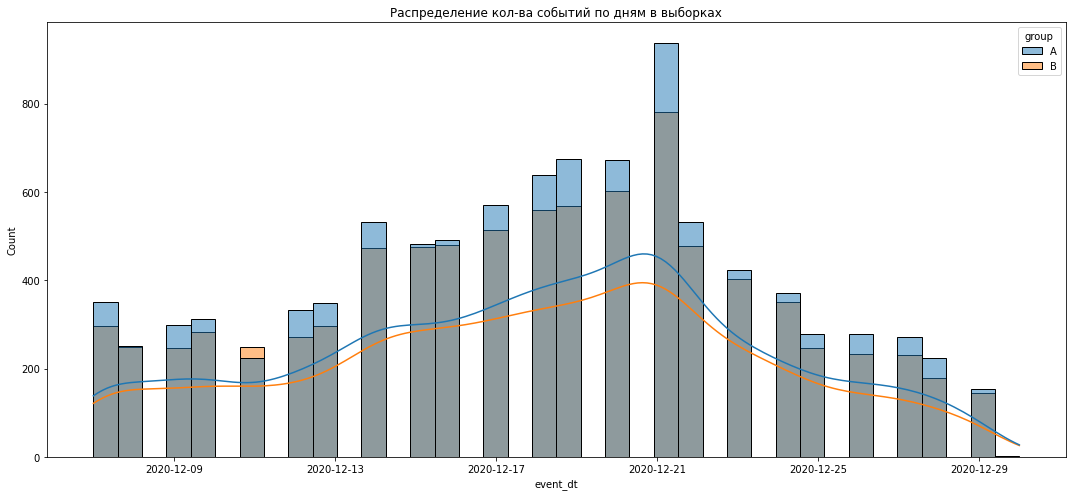

In [78]:
plt.figure(figsize=(15, 7))
sns.histplot(df,x=sessions['event_dt'],hue='group',kde=True)
plt.title('Распределение кол-ва событий по дням в выборках')
plt.tight_layout()

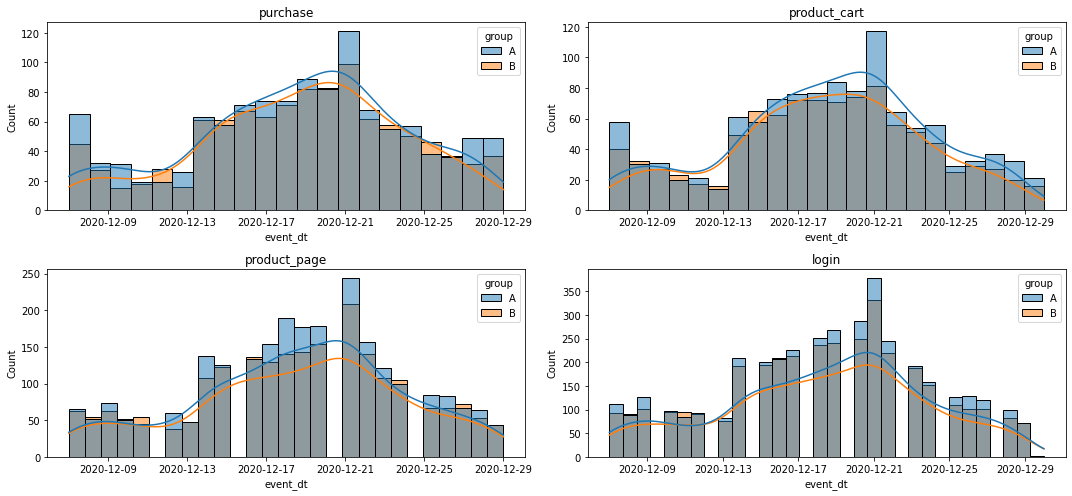

In [79]:
events = ['purchase', 'product_cart', 'product_page', 'login']
col_count, row_count =2,2 #число рядов и столбцов в сетке графиков
plt.figure(figsize=(15, 7))

for i, event in enumerate(events):
        sns.histplot(df,x=sessions.query('event_name==@event')['event_dt'],hue='group',kde=True,
                   ax=plt.subplot(row_count,col_count,i+1))
        plt.title(event)
plt.tight_layout()


Характер распределения кол-ва событий по дням схож в обеих выборках. Так как мы знаем из анализа дней жизни, что основной процент приходится на первые дни прихода пользователя в игру, то можно сопоставить такое распределение с кол-вом приходящих пользователей. Приход новых пользователей остановилмя 21.12.2021 и далее кол-во событий по нисходящей. В целом кол-во юзеров в группе А контрола изначально выше.

In [80]:
display(sessions.pivot_table(index='first_date',columns='group',values='user_id',aggfunc='nunique'))
display(sessions.groupby('group').agg({'user_id':'nunique'}))

group,A,B
first_date,,
2020-12-07,349,259
2020-12-08,186,149
2020-12-09,143,105
2020-12-10,189,181
2020-12-11,157,106
2020-12-12,268,198
2020-12-13,323,228
2020-12-14,366,262
2020-12-15,202,141


,user_id
group,
A,3634
B,2717


### Как меняется конверсия в воронке на разных этапах

In [81]:
def get_conversion(
    event,
    dimensions=[],
):
    first_event = (
        sessions.query('event_name==@event').sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index())

    test = test_full.merge(
        first_event[['user_id', 'event_dt']], on='user_id', how='left'
    )
    test['lifetime'] = (
        test['event_dt'] - test['first_date']
    ).dt.days

    df_event = test.dropna()
    result = df_event.pivot_table(
            index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
        )
    result = result.fillna(0)
    cohort_sizes = (
            test.groupby(dimensions)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
)
    result = cohort_sizes.merge(result, on=dimensions, how='left').fillna(0)
    result = result.div(result['cohort_size'], axis=0)
    result['cohort_size'] = cohort_sizes
    return result

def plot_conversion(result,i):    
    plt.figure(figsize=(10, 10))
    result = result.drop(columns=['cohort_size'])
    result.T.plot(kind='bar',grid=True,ax=plt.subplot(2,2,i+1))
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('{} Conversion noncumulative:'.format(event))


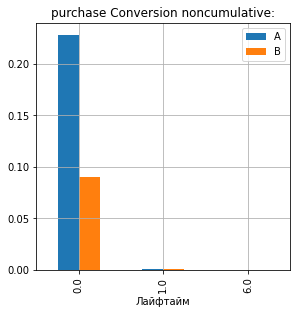

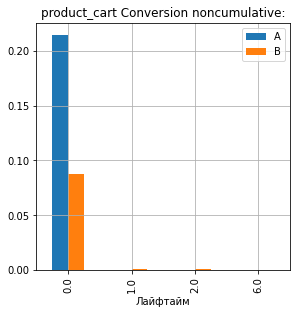

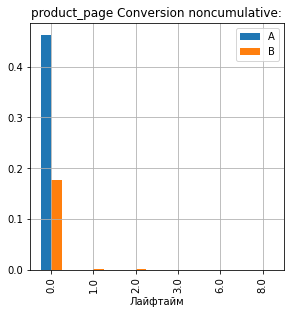

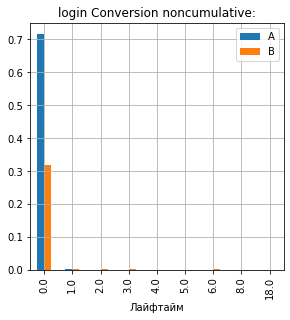

In [82]:
events = ['purchase', 'product_cart', 'product_page', 'login']
i=0
for event in events:
    result = get_conversion(event,['group'])
    plot_conversion(result,i)
    i+=1

Строим воронку для группы A

In [83]:
# кол-во уникальных пользователей, совершивших каждое событие 
def funnel(group,registration):
    event_funnel = sessions.query('group==@group').groupby('event_name').agg({'user_id':'nunique'}).reset_index()
    display(event_funnel)
    event_funnel = event_funnel.query('event_name!="registration"')
    event_registration = pd.DataFrame({'event_name':'registration','user_id':registration},index=np.arange(1))
    event_funnel = pd.concat([event_funnel,event_registration],axis=0).set_index('event_name')

   # конверсия пользователей в событие от общего числа уникальных пользователей
    event_funnel.columns = ['users_number']
    event_funnel = event_funnel.sort_values(by='users_number',ascending=False)
    event_funnel['% users_share'] = round((event_funnel['users_number']/len(sessions['user_id'].unique())*100),2)
    #event_funnel['% users_share'] = event_funnel['% users_share'].astype(str) + '%'
    return event_funnel
# воронка для группы А   
funnel_A = funnel("A",3634)
display(funnel_A)
# добавляем столбец с "конверсией в шаг"
funnel_A ['users_total'] = pd.Series([3634,3634,2604,1685,833],index=['registration','login','product_page',
'purchase','product_cart'])
funnel_A ['% users_share_step'] = round((funnel_A ['users_number']/funnel_A ['users_total'])*100,2)
funnel_A  = funnel_A .drop(columns=['users_total'])


,event_name,user_id
0,login,2604
1,product_cart,782
2,product_page,1685
3,purchase,833
4,registration,1030


,users_number,% users_share
event_name,,
registration,3634,57.22
login,2604,41.00
product_page,1685,26.53
purchase,833,13.12
product_cart,782,12.31


In [84]:
# воронка для группы B
funnel_B = funnel("B",2717)
display(funnel_B)
# добавляем столбец с "конверсией в шаг"
funnel_B['users_total'] = pd.Series([2717,2717,1840,493,249],index=['registration','login','product_page',
'purchase','product_cart'])
funnel_B['% users_share_step'] = round((funnel_B['users_number']/funnel_B['users_total'])*100,2)
funnel_B= funnel_B.drop(columns=['users_total'])

,event_name,user_id
0,login,877
1,product_cart,244
2,product_page,493
3,purchase,249
4,registration,1840


,users_number,% users_share
event_name,,
registration,2717,42.78
login,877,13.81
product_page,493,7.76
purchase,249,3.92
product_cart,244,3.84


In [85]:
# вывод воронки

fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'A',
    y = ["registration", "login", "product_page", "product_cart","purchase"],
    x = [3634, 2604, 1685, 782, 833],
    textinfo = "value+percent initial+percent previous"))
fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = ["registration", "login", "product_page", "product_cart","purchase"],
    x = [2717, 877, 493, 244, 249],
    
    textinfo = "value+percent initial+percent previous"))
fig.update_layout(
    autosize=False,
    width=1000,
    height=600)
fig.show()


### Вывод
     - Всего в логе событий:  26290
     - Кол-во юзеров: 6351
     - Всего в логе событий уникальных:  5
     - События  в логе:  ['purchase' 'product_cart' 'product_page' 'login' 'registration']
     - Среднее кол-во событий на пользователя:  4.0 (на самом деле 5, на данном этапе мы не учли факт регистрации)
     - Среднее кол-во событий на пользователя уникальных:  2.0 ( тут 3 соответственно)
     
     - Распределение событий схоже между тестами A и B:
     - наибольший процент событий приходится на день регистрации  
     - основная конверсия приходится на 1 день и далее распределяется аналогично в обеих группах
     - конверсия событий выше в группе A:
     - A: login-72%, product_page-46%, purchase-23%, product_cart-22%
     - B: login-32%, product_page-19%, purchase-9%, product_cart-9%
    

## Проверка разницы между конверсиями между тестом и когтролом. Оценка статистической значимости разницы z-критерием.

Прописываем формулу проверки равенства долей между группами. Помним, чтов задачах теста:
за 14 дней с момента регистрации улучшение каждой метрики не менее, чем на 10%:
конверсии в просмотр карточек товаров — событие product_page ,
просмотры корзины — product_cart
покупки — purchase


In [86]:
display(sessions.head())

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_cart,no_purchase
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25,product_cart,no_purchase
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_page,no_purchase


In [87]:
def test(sessions,event,exp1,exp2,a):
    test_funnel = sessions.groupby(['event_name','group']).agg({'user_id':'nunique'}).reset_index()
    
    # прописываем функцию для конверсия пользователей в событие N от общего числа уникальных пользователей
    test_funnel.columns = ['event_name','group','users_number']
    test_funnel = test_funnel.sort_values(by='users_number',ascending=False)
    group = sessions.groupby('group',as_index=False).agg({'user_id':'nunique'})
    group.columns = ['group','unique_users'] 
    test_funnel = test_funnel.merge(group,on=['group'])

    # считаем процент конверсии в каждое событие от общего кол-ва уникальных пользователей группы
    test_funnel['% users_share'] = round(test_funnel['users_number']/test_funnel['unique_users'],2)

    # выделяем событие, по которому рассчитывается ключевая метрика
    test_funnel = test_funnel[(test_funnel['event_name']==event)]
    users_exp1 = test_funnel[test_funnel['group']==exp1]
    users_exp2 = test_funnel[test_funnel['group']==exp2]
    test_funnel = (pd.concat([users_exp1,users_exp2],axis=0)).reset_index(drop=True)
    
    
    # Проверяем гипотезу о равенстве долей в этих двух группах-Ho
    # Альтернативная гипотеза-между долями есть разница-H1
  
    alpha = a  
    p1 = test_funnel['% users_share'][0]
    p2 = test_funnel['% users_share'][1]
    
    # транслируем полученные доли
    print('Доли в каждой группе: ',p1,p2)
    print('Разница в долях: ',round(p1/p2,2))
          
    p_combined = (test_funnel['users_number'].sum())/(test_funnel['unique_users'].sum())
    difference = p1-p2
    z_value = difference/mth.sqrt(p_combined*(1-p_combined)*(1/test_funnel['unique_users'][0]+1/test_funnel['unique_users'][1])) 

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0,1)
    
    p_value = (1-distr.cdf(abs(z_value)))*2 
            
    print('p-значение: ', p_value)
    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
         )

Изначальный уровень статистической значимости 0.05. У нас всего 3 проверки. Применяем поправку Бонферрони и уровень получается равным 0,017.events =[product_page, product_cart,purchase]

In [88]:
# Проверяем гипотезу о равенстве конверсий в product_page в этих двух группах-Ho
# Альтернативная гипотеза-между конверсиями  есть разница-H1
test_funnel = test(sessions,'product_page','A','B',0.017)


Доли в каждой группе:  0.46 0.18
Разница в долях:  2.56
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [89]:
# Проверяем гипотезу о равенстве конверсий в product_cart в этих двух группах-Ho
# Альтернативная гипотеза-между конверсиями  есть разница-H1
test_funnel = test(sessions,'product_cart','A','B',0.017)

Доли в каждой группе:  0.22 0.09
Разница в долях:  2.44
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [90]:
# Проверяем гипотезу о равенстве конверсий в purchase в этих двух группах-Ho
# Альтернативная гипотеза-между конверсиями  есть разница-H1
test_funnel = test(sessions,'purchase','A','B',0.017)

Доли в каждой группе:  0.23 0.09
Разница в долях:  2.56
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


#### Вывод
   -  Разница в конверсии группы B (теста) изменилась на:
   -  в 'product page' на 28% ниже, между долями значимая разница
   -  в 'product_cart' на 13% ниже, между долями значимая разница
   -  в 'purchase' на 14% ниже,между долями значимая разница

##### Вывод:
- Выборка для теста произведена некорректно, так как не соответствует ТЗ:
- В ТЗ было заявлено, что кол-во участников для теста должно составлять 15% новых пользователей из Европы, т.е. 6940
  По факту оно составляет 14% - 6351. Проверка выше показала, что между долями есть статистически значимая разница.
  Из 6700 пользователй, заявленных в тесте 5% не соответствуют условию, поэтому отбрасываются. Они принадлежат следующим       регионам по процентам:
  
- APAC		20.57
- CIS	    15.71
- N.America	63.71
  
- есть пересечение пользователй между 2-мя разными тестами. Доля общих участников в каждой из тестовых групп составляет          - 25%
- есть пересечение времени проведения теста с другой маркетинговой акцией: Christmas&New Year Promo, проводимой в EU,            - и N.America с 2020-12-25 по 2021-01-03. 30% и 40% от всех участников попадают в период проведения маркетинговой акции          - в группах А и В соответственно 
     
- Всего в логе событий:  26290
- Кол-во юзеров: 6351
- Всего в логе событий уникальных:  5
- События  в логе:  ['purchase' 'product_cart' 'product_page' 'login' 'registration']
- Среднее кол-во событий на пользователя:  4.0 (на самом деле 5, на данном этапе мы не учли факт регистрации)
- Среднее кол-во событий на пользователя уникальных:  2.0 ( тут 3 соответственно)
     
- Распределение событий схоже между тестами A и B:
- наибольший процент событий приходится на день регистрации  
- основная конверсия приходится на 1 день и далее распределяется аналогично в обеих группах
- конверсия событий выше в группе A:
- A: login-72%, product_page-46%, purchase-23%, product_cart-22%
- B: login-32%, product_page-19%, purchase-9%, product_cart-9%

-  Разница в конверсии группы B (теста) изменилась на:
-  в 'product page' на 28% ниже, между долями значимая разница
-  в 'product_cart' на 13% ниже, между долями значимая разница
-  в 'purchase' на 14% ниже,между долями значимая разница
     

     
- В целом выборка некорректна и опровергает выводы о росте метрик на 10% в тесте по отношению контролу